#**Can how you spend your free time predict who you'll vote for?**
###Edwin Savelson
**Summary:** <br>
In this project, I am exploring data published by the United States Bureau of Labor Statistics published in their annual American Time Use Survey(ATUS).  The ATUS collects information on how Americans are using their time- e.g. Hobbies, Jobs, etc.  

**Goal:** <br>
I will let a model perform binary classification using a variety of features on the provided data with minimal intervention then compare that classification to the results of the 2024 Presidential Election with each state's cast vote representing a binary classification.

*This project uses the [data published here](https://www.bls.gov/tus/data/datafiles-2023.htm).*

## Important notes/declarations about this data exploration:
- There is no infomation on the respondents' actual or lack of actual vote cast.
- It is not known who within the sample voted.
- If the person voted, it is not known for whom they voted.
- There is not an equal number respondents on each state.
- Only data from the 2023 ATUS will be included.

#### Assumptions:
- All of the respondents were truthful.
- The respondent voted for the candidate who won a majority of the State's electoral votes. It is possible to separate the State's voting population into two groups and run a simulation based on the probability that a randomly selected member of the population voted for the winning candidate and assume their voting preference- but, for simplicity, I will assume that all respondents from a given state voted for the majority candidate.  E.G. All respondents from Colorado voted for the Democratic Candidate.

#### Data that is being ignored:
- States with little to no data(parameters to be determined) will be omitted.

# Predictions:
- Just as the electoral map largely matches the map of average income(Individuals in Red States tend to make less than Blue States), I predict that amount of free time and income level will be reflected in the hobbies in which the respondents participate and thus will predict their vote.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## **<font color='red'>EXPLORATORY DATA ANALYSIS (EDA)</font>**
### How is the data seperated?
This data is HARD to decipher, mostly because the headings are meaningless without the dictionary of initialisms provided [here](https://github.com/EdwinSavelson/CS3120_Final_Project/blob/main/freqvariables.pdf).  
There are **592** columns(Infinitely more given the encoding later in the project) in this data so attempting to analyze all of these features would be an undertaking outside the scope of this project.

### A few headings relevant to my exploration include:

| Code | Explanation  | Possible Responses |
|------|------|-----|
|GESTFIPS |State from which the respondent responded to the survey | [FIPS State code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)|
|GEREG| Geographic Region|1 = Northeast, 2 = Midwest, 3 = South, 4 = West|
|EMPSTAT| Employment Status|1 = Employed, 2 = Employed(Absent), 3 = Unempoyed on Layoffs, 4 = Unemployed(looking), 5 = Not in Labor Force|
|ACTIVITY|Activity in which the respondent participated| All codes [here](https://www.bls.gov/tus/lexicons/lexiconwex2023.pdf)|




In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atuscperson_2023.dat')
df2= pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atusactivity_2023.dat')
df3 = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atusresp_2023.dat')
data= pd.merge(df1, df2, on='TUCASEID')
data= pd.merge(data, df3, on='TUCASEID')
print(f"** df has {data.shape[0]} rows and {data.shape[1]} columns **")
data.head()


** df has 371676 rows and 592 columns **


,TUCASEID,TULINENO_x,GEREG,GEDIV,GESTFIPS,GTMETSTA,GTCBSA,GTCO,HEFAMINC,HEHOUSUT,...,TXSPUHRS,TXTCC,TXTCCTOT,TXTCOC,TXTHH,TXTNOHH,TXTO,TXTOHH,TXTONHH,TREMODR
0,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
1,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
2,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
3,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
4,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1


The sample size of this data(approx 372k) is small relative to the population of the United States who voted in the (approx 158M), assumably because the survey is quite work intensive for the participant.

In [3]:
# Declare some variables for easy access
state = "GESTFIPS"
activity = "TUTIER1CODE"
employment = "TELFS"

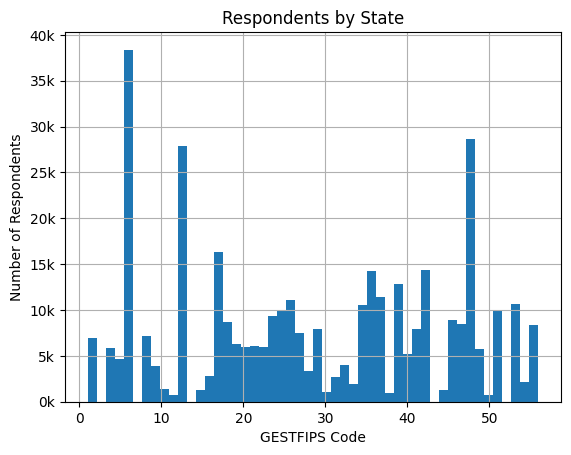

,0
GESTFIPS,
1,6086
2,912
4,5901
5,4622
6,38384
8,7155
9,3910
10,1433
11,723


In [4]:
ax = data[state].hist(bins=50)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x /1000)}k'))

plt.xlabel('GESTFIPS Code')
plt.ylabel('Number of Respondents')
plt.title('Respondents by State')

plt.show()
data.columns = data.columns.str.strip()

data.groupby(state).size()


## Import actual election results

In [5]:
election_results_df = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/us_states_party_labels.csv')
state_voting_map = pd.Series(election_results_df.Party.values, index=election_results_df.State).to_dict()
print(state_voting_map)

{'Alabama': 'Republican', 'Alaska': 'Republican', 'Arizona': 'Republican', 'Arkansas': 'Republican', 'California': 'Democrat', 'Colorado': 'Democrat', 'Connecticut': 'Democrat', 'Delaware': 'Democrat', 'District of Columbia': 'Democrat', 'Florida': 'Republican', 'Georgia': 'Republican', 'Hawaii': 'Democrat', 'Idaho': 'Republican', 'Illinois': 'Democrat', 'Indiana': 'Republican', 'Iowa': 'Republican', 'Kansas': 'Republican', 'Kentucky': 'Republican', 'Louisiana': 'Republican', 'Maine': 'Democrat', 'Maryland': 'Democrat', 'Massachusetts': 'Democrat', 'Michigan': 'Republican', 'Minnesota': 'Democrat', 'Mississippi': 'Republican', 'Missouri': 'Republican', 'Montana': 'Republican', 'Nebraska': 'Republican', 'Nevada': 'Republican', 'New Hampshire': 'Democrat', 'New Jersey': 'Democrat', 'New Mexico': 'Democrat', 'New York': 'Democrat', 'North Carolina': 'Republican', 'North Dakota': 'Republican', 'Ohio': 'Republican', 'Oklahoma': 'Republican', 'Oregon': 'Democrat', 'Pennsylvania': 'Republican

## Preprocessing

*   Edit data so that FIPS codes are read as state names rather than numbers
*   Drop rows with missing information in any of the desired features
*   Ensure that categorical data is processed as such- everything is a code(e.g. employed = 1, unemployed = 2), so I ran into a lot of errors in processing the code as an int rather than a string.

In [6]:
# Map the FIPS codes to state names
fips_mapping = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/fips_to_state.csv')
fips_to_state = pd.Series(fips_mapping.state.values, index=fips_mapping.fips).to_dict()
data['state_name'] = data[state].map(fips_to_state)
# Add column for voting results
data['voting_preference'] = data['state_name'].map(state_voting_map)

# Handle missing values
# data = data.dropna(subset=[employment, activity])

# Handle data as categorical(codes)
data[activity] = data[activity].astype('category')
data[employment] = data[employment].astype('category')

# Check for NaN values
if (data.isnull().sum() > 0).any():
    print(data.isnull().sum())

data.groupby(activity).size()

<ipython-input-6-bb3b57211bec>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(activity).size()


,0
TUTIER1CODE,
1,72457
2,62442
3,22229
4,3279
5,16782
6,2000
7,12107
8,1527
9,375


## Key of Activities

| Number | Activity                                   |
|--------|-------------------------------------------|
| 1      | Personal Care                             |
| 2      | Household Activities                      |
| 3      | Caring For & Helping Household Members    |
| 4      | Caring For & Helping Non-Household Members|
| 5      | Work & Work-Related Activities            |
| 6      | Education                                 |
| 7      | Consumer Purchases                        |
| 8      | Professional & Personal Care Services     |
| 9      | Household Services (Not done by self)     |
| 10     | Government Services & Civic Obligations   |
| 11     | Eating and Drinking                       |
| 12     | Socializing, Relaxing, and Leisure        |
| 13     | Sports, Exercise, and Recreation          |
| 14     | Religious and Spiritual Activities        |
| 15     | Volunteer Activities                      |
| 16     | Telephone Calls                           |
| 17     | There is no 17; I don't know why          |
| 18     | Traveling                                 |
| 50     | Insufficient Data                         |


# **<font color='red'>MODELING</font>**
## Feature Engineering


In [7]:

# Cluster individuals based on selected features
selected_features = [employment,activity]

# One-Hot encoding because the columns are categorical and k-means does not work with it otherwise
data = pd.get_dummies(data, columns=[employment, activity])

# Reselect columns after renaming
selected_features = [col for col in data.columns if col.startswith((employment, activity))]

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(data[selected_features])

# Count clusters per state
cluster_counts = (
    data.groupby(['state_name', 'cluster'])
    .size()  # Count the occurrences of each cluster within each state
    .unstack(fill_value=0)  # Pivot the table to get clusters as columns
    .reset_index()
)

# Aggregate features by state
aggregated_data = (
    data.groupby('state_name')
    .agg({col: 'mean' for col in selected_features})  # Aggregate one-hot encoded columns
    .reset_index()
)

# Merge the two DataFrames
state_level_data = pd.merge(cluster_counts, aggregated_data, on='state_name')

# Add voting preference Republican or Democrat
state_level_data['voting_preference'] = state_level_data['state_name'].map(state_voting_map)

# Binary Classification/Model Training


In [8]:
X = state_level_data.drop(columns=['state_name', 'voting_preference'])
X.columns = X.columns.astype(str)
# Drop rows containing missing values
X = X.dropna()

y = state_level_data['voting_preference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # STRATIFY TO KEEP 50 States
#
# X_with_state = X.copy()
# X_with_state['state_name'] = state_level_data['state_name']

# # Stratified split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_with_state, y,
#     test_size=0.3,
#     random_state=42,
#     stratify=X_with_state['state_name']
# )

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

# Step 4: Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

    Democrat       0.67      0.22      0.33         9
  Republican       0.46      0.86      0.60         7

    accuracy                           0.50        16
   macro avg       0.56      0.54      0.47        16
weighted avg       0.58      0.50      0.45        16



16
Predictions by State:
              state_name      actual   predicted
0               Arkansas  Republican  Republican
1             California    Democrat    Democrat
2            Connecticut    Democrat  Republican
3   District of Columbia    Democrat  Republican
4                  Idaho  Republican    Democrat
5               Illinois    Democrat  Republican
6               Kentucky  Republican  Republican
7            Mississippi  Republican  Republican
8             New Jersey    Democrat  Republican
9             New Mexico    Democrat  Republican
10              New York    Democrat  Republican
11        South Carolina  Republican  Republican
12                 Texas  Republican  Republican
13              Virginia    Democrat  Republican
14            Washington    Democrat    Democrat
15             Wisconsin  Republican  Republican


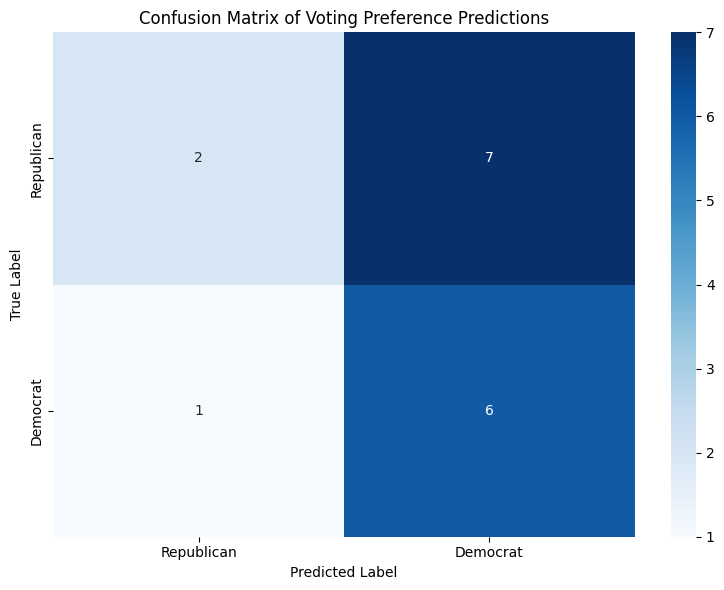

<ipython-input-9-162e6d0c7e78>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_accuracy = predictions_df.groupby('state_name').apply(


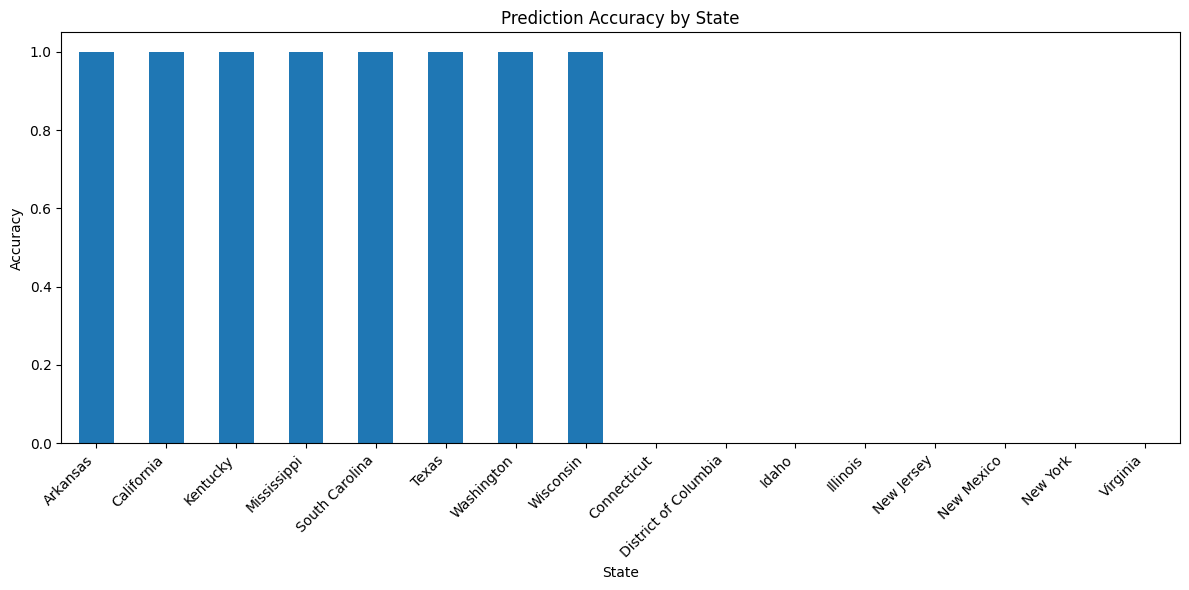

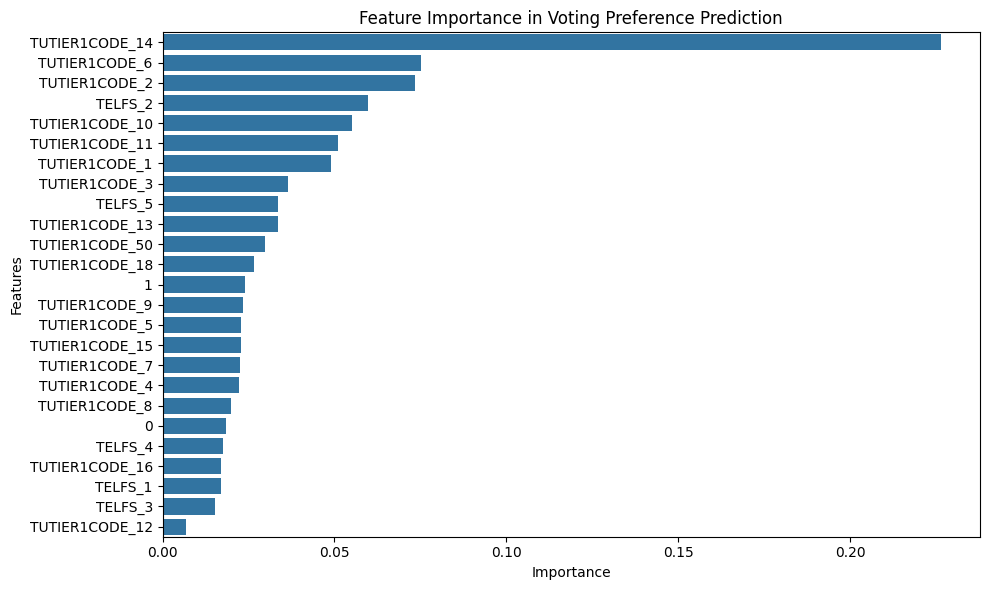

In [9]:

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({
    'state_name': state_level_data.loc[X_test.index, 'state_name'],
    'actual': y_test,
    'predicted': y_pred
})


print(predictions_df['state_name'].nunique())
# Detailed predictions by state
print("Predictions by State:")
detailed_predictions = predictions_df.groupby('state_name').agg({
    'actual': 'first',  # Actual voting preference for the state
    'predicted': lambda x: x.mode()[0]  # Most common prediction
}).reset_index()
print(detailed_predictions)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Republican', 'Democrat'],
            yticklabels=['Republican', 'Democrat'])
plt.title('Confusion Matrix of Voting Preference Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Visualization 2: Prediction Accuracy by State
plt.figure(figsize=(12, 6))
state_accuracy = predictions_df.groupby('state_name').apply(
    lambda x: np.mean(x['actual'] == x['predicted'])
).sort_values(ascending=False)

state_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by State')
plt.xlabel('State')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 3: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Voting Preference Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Additional Analysis
print("\nModel Performance Metrics:")
print(classification_report(y_test, y_pred))

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

## Findings:
I find it very interesting that Religious activity was a significant feature in determining vote. I wish that I could have spent more time digging into the data but it was like sifting through an encyclopedia in another language.

## Reflection

This project was incredibly interesting and made me want to pursue machine learning further, but this data set is ridiculous.
99.9999% of my time was spent trying to get the data to work/understand the headings.  
Additionally, because of how I processed the data, I crashed Colab 20+ times because I was trying to store so much data in memory.

I chose a random forest model because of its handling of categorical data well; and K-means because I needed a way to group that categorical data before training the model.  I could have used gradient boosting, but I did not know what features would be worth boosting, or if the data would respond well to it.





<hr style="height:2px;border-width:0;color:black;background-color:black">




